In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pacmap import PaCMAP

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


patient_embeddings shape:  (896, 32, 1024)
flat_embeddings shape:  (28672, 1024)
Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=80, n_FP=150, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((286720, 2), (2293760, 2), (4300800, 2))
Initial Loss: 2427250.75
Iteration:   10, Loss: 1990443.500000
Iteration:   20, Loss: 1666495.250000
Iteration:   30, Loss: 1522347.375000
Iteration:   40, Loss: 1401465.000000
Iteration:   50, Loss: 1308508.000000
Iteration:   60, Loss: 1212183.250000
Iteration:   70, Loss: 1104550.500000
Iteration:   80, Loss: 980049.812500
Iteration:   90, Loss: 825310.062500
Iteration:  100, Loss: 622122.500000
Iteration:  110, Loss: 577725.812500
Iteration:  120, Loss: 524326.687500
Iteration:  130, Loss: 484344.312500
Iteration:  140, Loss: 454102.750000
Iteration

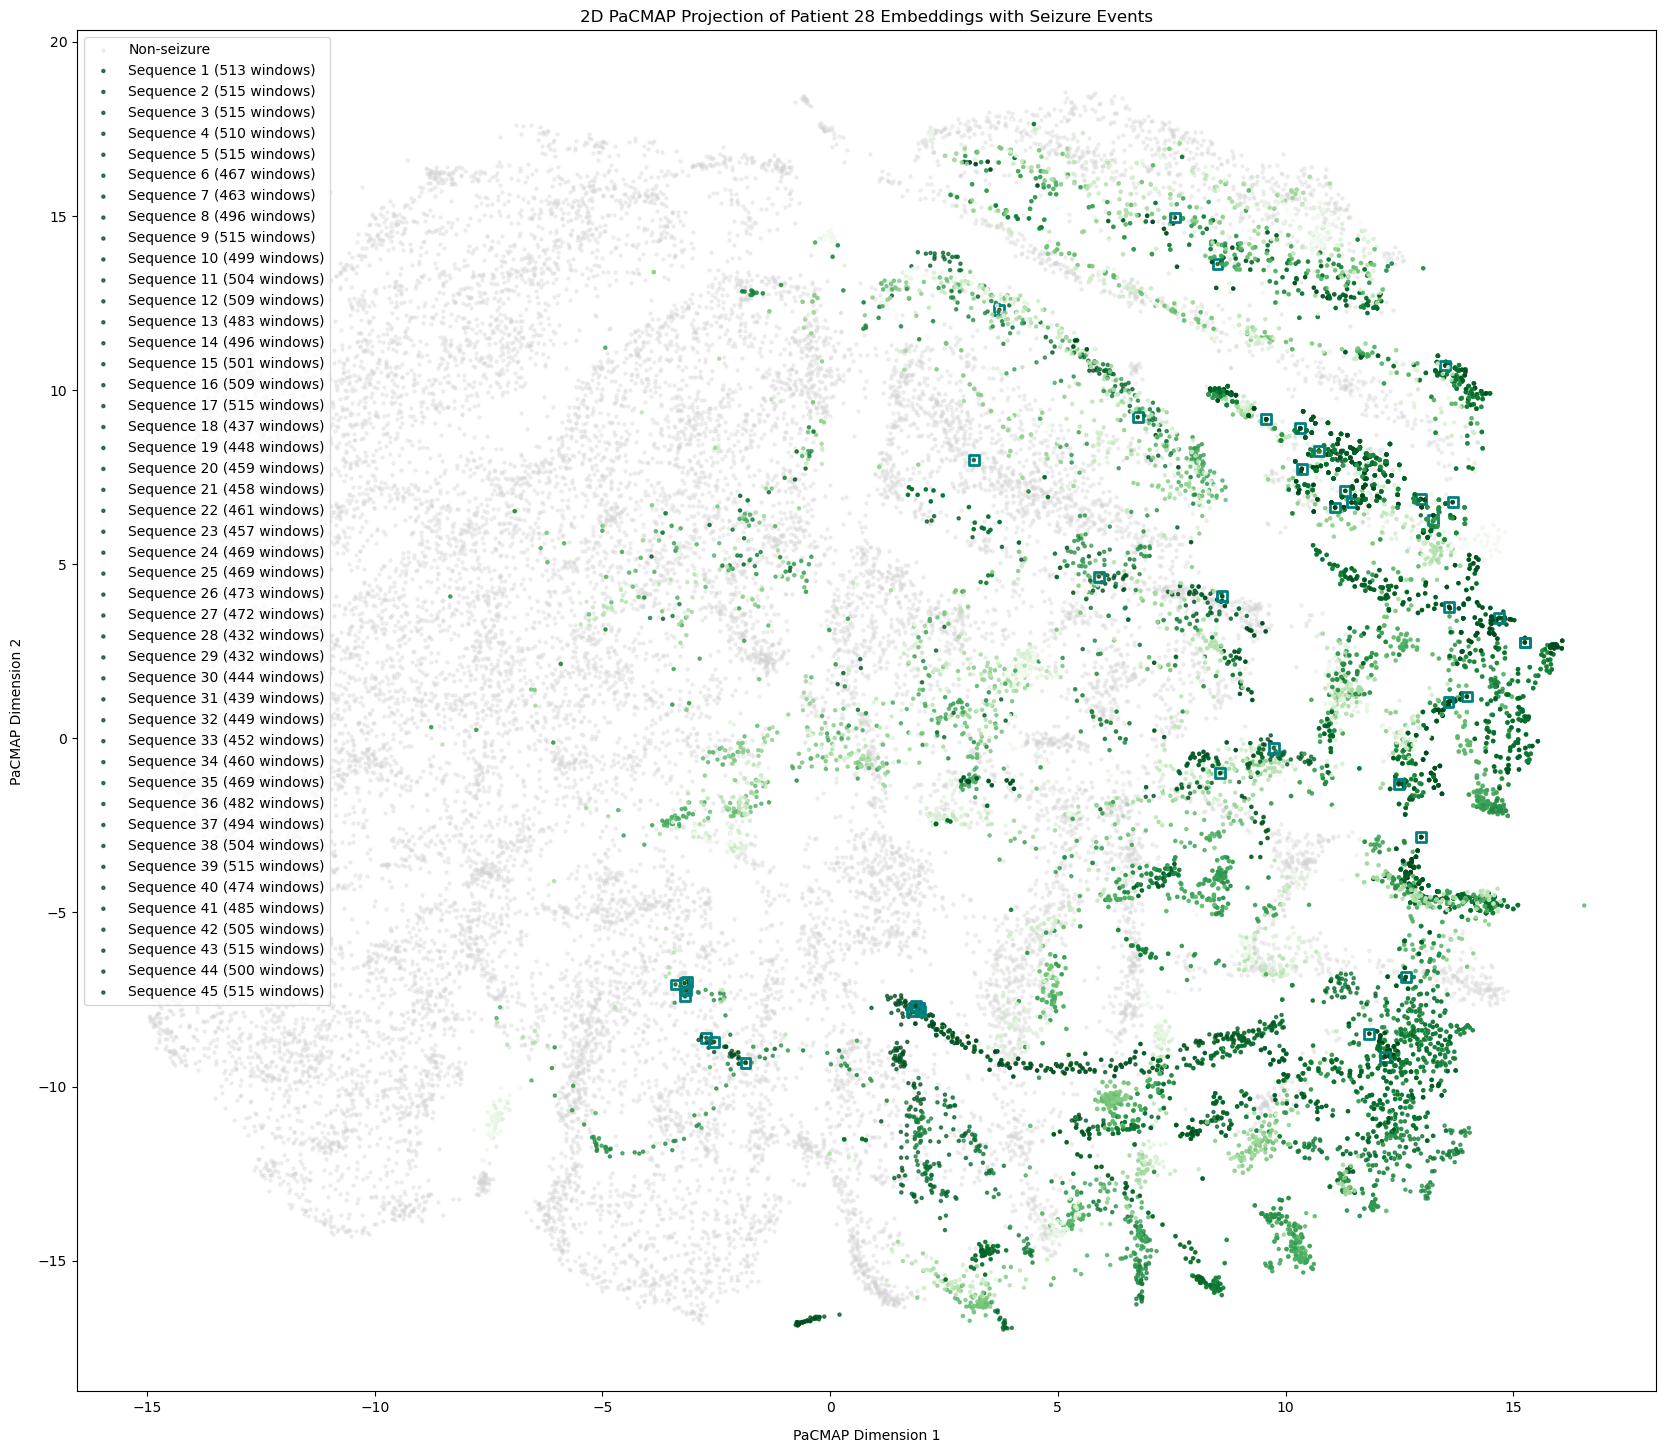

In [7]:
patient_id = 28
mn_ratio = 8
fp_ratio = 15
lr = 0.05

animal = 'pangolin'

# Format data
embedding_path = f'output/{animal}/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'

with open(embedding_path, 'rb') as f:
    patient_data = pickle.load(f)

patient_embeddings = patient_data['patient_embeddings'] # (num_files, 32, 512)
print('patient_embeddings shape: ', patient_embeddings.shape)

with open(embedding_path, 'rb') as f:
    patient_data = pickle.load(f)

patient_embeddings = patient_data['patient_embeddings']
flat_embeddings = patient_embeddings.reshape(-1, patient_embeddings.shape[-1])
print('flat_embeddings shape: ', flat_embeddings.shape)

pacmap_params = {
    'n_components': 2,
    'MN_ratio': mn_ratio,
    'FP_ratio': fp_ratio,
    'distance': 'angular',
    'verbose': True,
    'lr': 0.05,
    'num_iters': 900
}

project_to_2d = PaCMAP(**pacmap_params)
manifold_2d = project_to_2d.fit_transform(flat_embeddings)

seizure_data = pd.read_excel('metadata/ictal_event_metadata.xlsx')
patient_seizures = seizure_data[(seizure_data['Pat ID'] == f"Epat{patient_id}")]

if len(patient_seizures) == 0:
    print(f"No seizure events found for patient {patient_id}")
else:
    print(f"Found {len(patient_seizures)} seizure events for patient {patient_id}")

num_seizure_events = len(patient_seizures)

# Process timestamps for the filtered data
patient_seizures = patient_seizures[
    ~(
        patient_seizures['Date (MM:DD:YYYY)'].isna() |
        patient_seizures['Electrographical Ictal Onset (HH:MM:SS) 24Hr'].isna() |
        patient_seizures['Electrographic Ictal Offset (HH:MM:SS) 24Hr'].isna()
    )
]

# Convert date format and create datetime objects
patient_seizures['Date (MM:DD:YYYY)'] = patient_seizures['Date (MM:DD:YYYY)'].apply(lambda x: x.split(':')[0] + '/' + x.split(':')[1] + '/' + x.split(':')[2])

date_format = '%m/%d/%Y %H:%M:%S'
patient_seizures['onset_datetime'] = pd.to_datetime(
    patient_seizures['Date (MM:DD:YYYY)'] + ' ' + 
    patient_seizures['Electrographical Ictal Onset (HH:MM:SS) 24Hr'],
    format=date_format
)

patient_seizures['offset_datetime'] = pd.to_datetime(
    patient_seizures['Date (MM:DD:YYYY)'] + ' ' + 
    patient_seizures['Electrographic Ictal Offset (HH:MM:SS) 24Hr'],
    format=date_format
)

# Get original file start times
file_start_times = patient_data['start_times']

# Create expanded list of start times for each window
expanded_start_times = []
for file_start in file_start_times:
    # For each file, create 32 window start times with 30-second strides
    window_starts = [file_start + pd.Timedelta(seconds=30*i) for i in range(32)]
    expanded_start_times.extend(window_starts)

# Convert to numpy array if needed
expanded_start_times = np.array(expanded_start_times)

# Verify dimensions
print("Number of windows:", len(expanded_start_times))
print("Flat embeddings shape:", flat_embeddings.shape)
assert len(expanded_start_times) == flat_embeddings.shape[0], "Dimensions should match"

# Create mask for seizure windows
seizure_mask = np.zeros(len(expanded_start_times), dtype=bool)

# Each window is 30 seconds long
window_duration = pd.Timedelta(seconds=30)

# Check each window for overlap with seizures
for i, window_start in enumerate(expanded_start_times):
    window_end = window_start + window_duration
    
    # Check if window overlaps with any seizure
    for _, seizure in patient_seizures.iterrows():
        if (
            # Window starts during seizure
            (window_start >= seizure['onset_datetime'] and window_start <= seizure['offset_datetime']) or
            # Window ends during seizure  
            (window_end >= seizure['onset_datetime'] and window_end <= seizure['offset_datetime']) or
            # Window contains entire seizure
            (window_start <= seizure['onset_datetime'] and window_end >= seizure['offset_datetime'])
        ):
            seizure_mask[i] = True
            break

# Define post-ictal window duration (4 hours)
postictal_window = pd.Timedelta(minutes=240)

# Create mask for post-ictal windows
postictal_mask = np.zeros(len(expanded_start_times), dtype=bool)

# Find the end of each seizure sequence
seizure_sequence_ends = []
for i in range(len(seizure_mask)-1):
    if seizure_mask[i] and not seizure_mask[i+1]:
        seizure_sequence_ends.append(i)
# Add the last seizure if it ends at the very end of our data
if seizure_mask[-1]:
    seizure_sequence_ends.append(len(seizure_mask)-1)

# Create dictionary to store post-ictal sequences
postictal_sequences = {}

# For each seizure end, create a separate sequence
for seizure_end_idx in seizure_sequence_ends:
    seizure_end_time = expanded_start_times[seizure_end_idx] + window_duration
    postictal_sequence = []
    
    # Look at all windows after this seizure
    for i in range(seizure_end_idx + 1, len(expanded_start_times)):
        window_time = expanded_start_times[i]
        time_from_seizure = window_time - seizure_end_time
        
        # If window is within postictal period after seizure and not already marked as seizure
        if (time_from_seizure <= postictal_window and 
            time_from_seizure >= pd.Timedelta(seconds=0) and 
            not seizure_mask[i]):
            postictal_sequence.append(i)
            postictal_mask[i] = True  # Mark this window in the overall mask
    
    if postictal_sequence:  # Only store sequences that have points
        postictal_sequences[seizure_end_idx] = postictal_sequence
# Plot results
plt.figure(figsize=(20, 15))  # Make figure larger

# Plot non-seizure points in grey first
plt.scatter(manifold_2d[~(seizure_mask | postictal_mask),0], 
           manifold_2d[~(seizure_mask | postictal_mask),1],
           c='lightgray', alpha=0.3, s=5, label='Non-seizure')

# Plot each post-ictal sequence separately
colors = plt.cm.Greens(np.linspace(0.2, 0.8, len(postictal_sequences)))
for idx, ((seizure_idx, sequence), color) in enumerate(zip(postictal_sequences.items(), colors)):
    # Create normalized values for this sequence
    sequence_norm_values = np.linspace(0, 1, len(sequence))
    
    # Plot this post-ictal sequence with shorter label
    plt.scatter(manifold_2d[sequence, 0], 
               manifold_2d[sequence, 1],
               c=sequence_norm_values, 
               cmap='Greens_r',
               label=f'Sequence {idx+1} ({len(sequence)} windows)',
               alpha=0.7, s=5)
    
    # Mark the start of this post-ictal sequence
    plt.scatter(manifold_2d[sequence[0], 0],
               manifold_2d[sequence[0], 1], 
               facecolors='none', edgecolors='teal', 
               s=50, linewidth=2, marker='s')

plt.title(f'2D PaCMAP Projection of Patient {patient_id} Embeddings\nPost-ictal Sequences', 
          pad=20)  # Add padding to title
plt.xlabel('PaCMAP Dimension 1', labelpad=10)  # Add padding to x-label
plt.ylabel('PaCMAP Dimension 2', labelpad=10)  # Add padding to y-label

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          borderaxespad=0.,
          title="Post-ictal Sequences")

# Adjust layout to prevent cutting off
plt.tight_layout()

plt.savefig(f'figures/{animal}/seizures/postictal_4hr_Epat{patient_id}_MN{mn_ratio}_FP{fp_ratio}.svg', 
            format='svg', 
            bbox_inches='tight',
            dpi=300)
plt.title(f'2D PaCMAP Projection of Patient {patient_id} Embeddings with Seizure Events')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.legend()
plt.savefig(f'figures/{animal}/seizures/postictal_4hr_Epat{patient_id}_MN{mn_ratio}_FP{fp_ratio}.svg', format='svg', bbox_inches='tight')

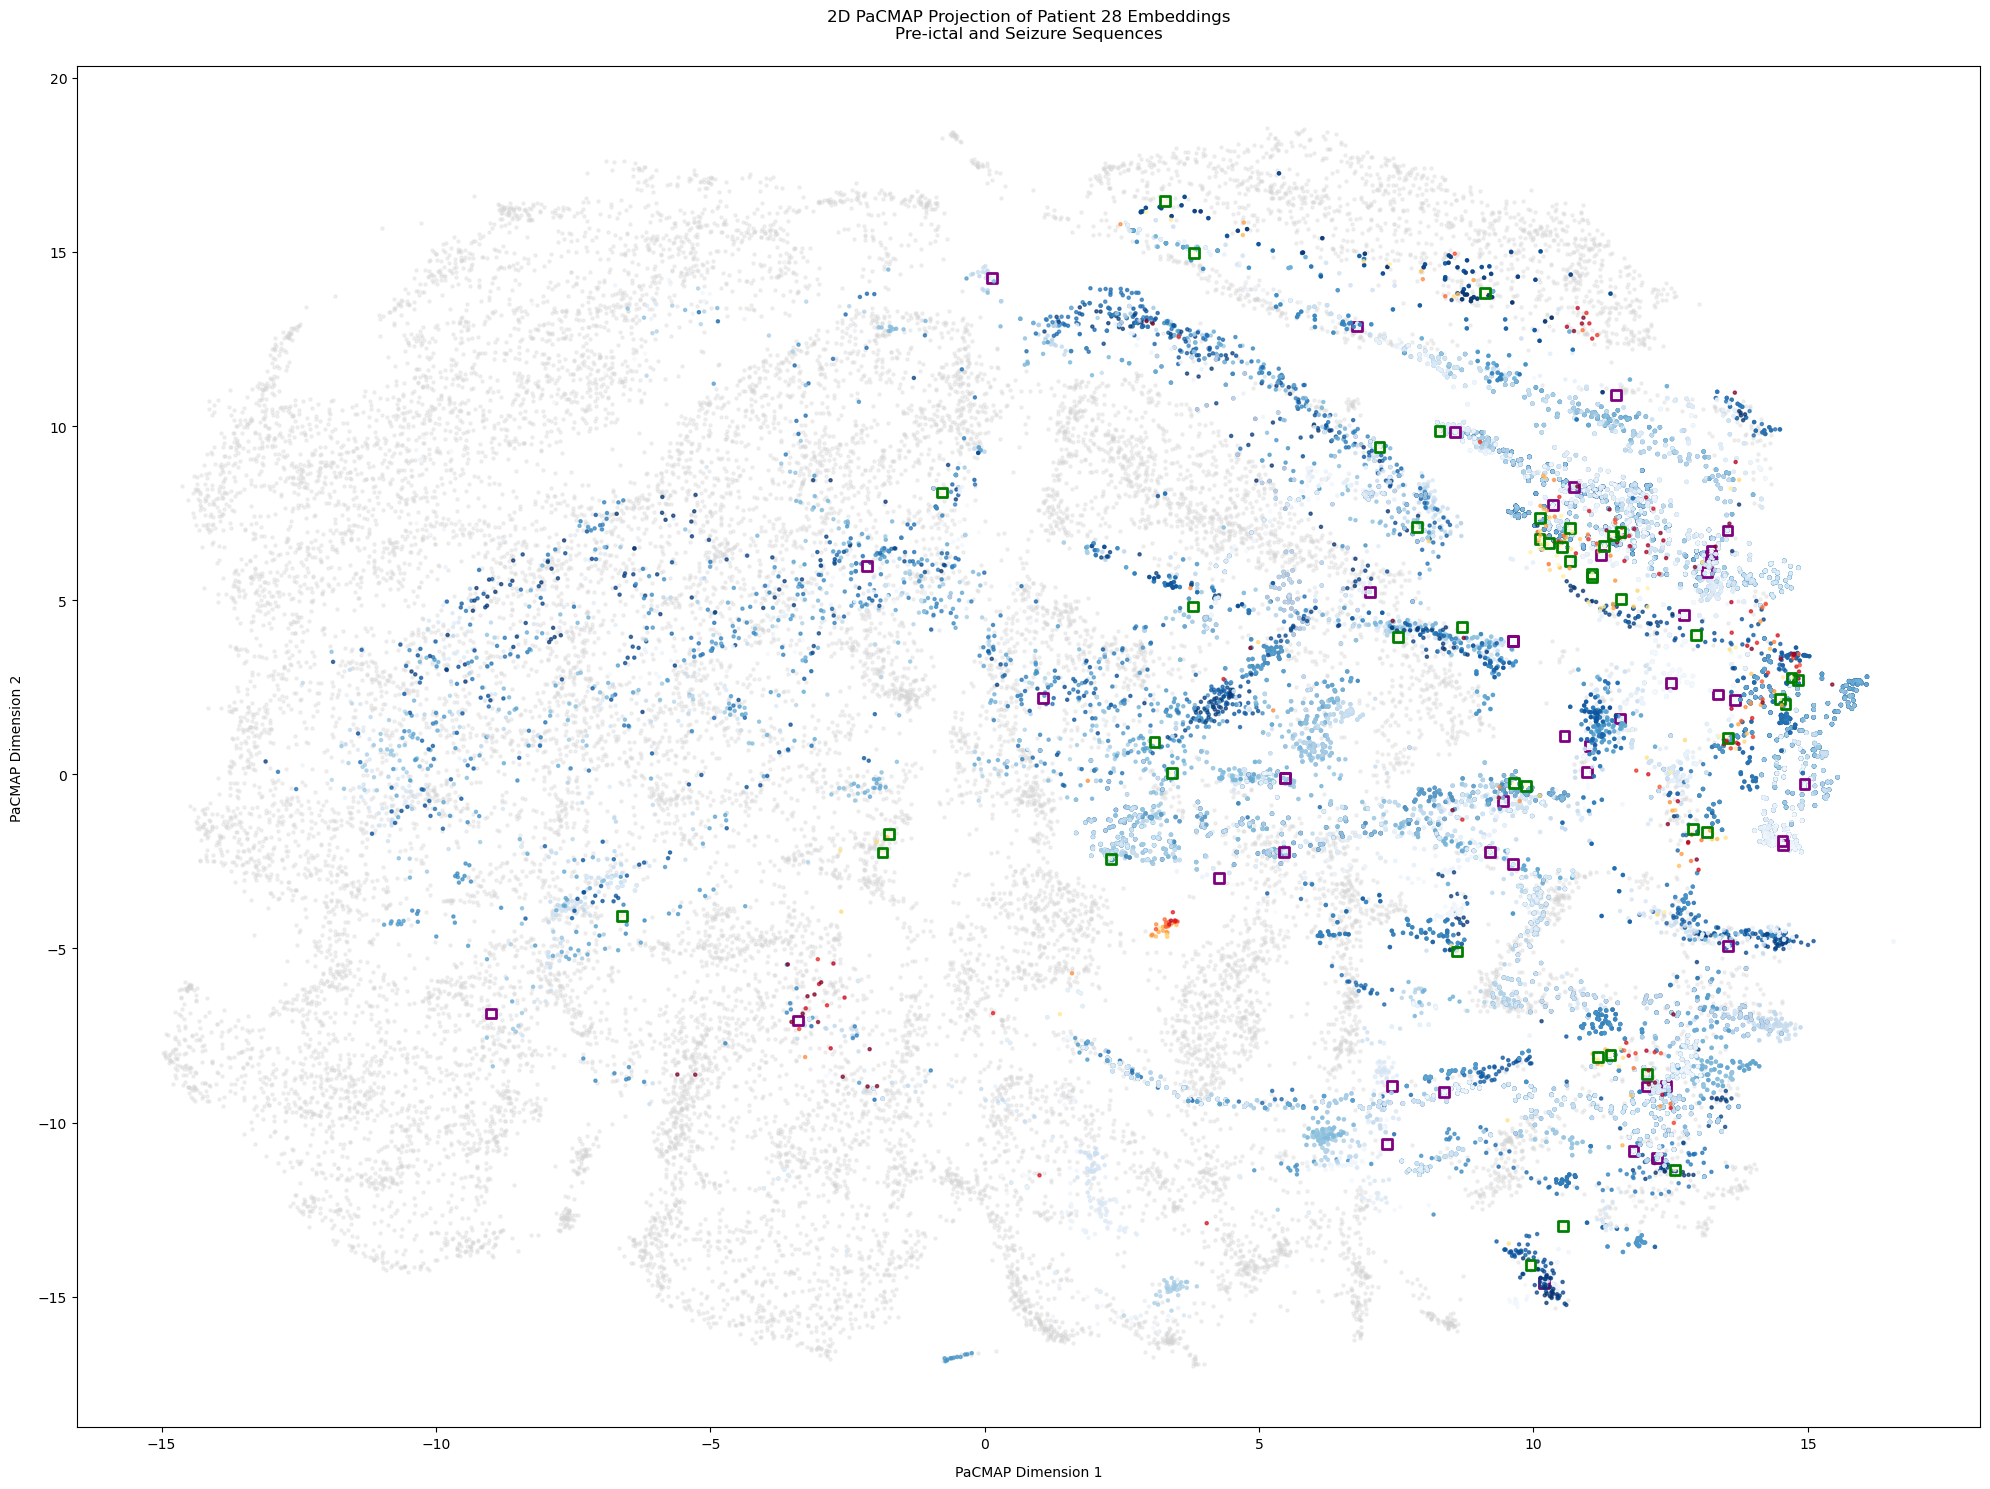

In [10]:
# Create mask for seizure windows
seizure_mask = np.zeros(len(expanded_start_times), dtype=bool)

# Each window is 30 seconds long
window_duration = pd.Timedelta(seconds=30)

# Check each window for overlap with seizures
for i, window_start in enumerate(expanded_start_times):
    window_end = window_start + window_duration
    
    # Check if window overlaps with any seizure
    for _, seizure in patient_seizures.iterrows():
        if (
            # Window starts during seizure
            (window_start >= seizure['onset_datetime'] and window_start <= seizure['offset_datetime']) or
            # Window ends during seizure  
            (window_end >= seizure['onset_datetime'] and window_end <= seizure['offset_datetime']) or
            # Window contains entire seizure
            (window_start <= seizure['onset_datetime'] and window_end >= seizure['offset_datetime'])
        ):
            seizure_mask[i] = True
            break
# Define window durations (4 hours each)
preictal_window = pd.Timedelta(minutes=240)

# Create masks
preictal_mask = np.zeros(len(expanded_start_times), dtype=bool)

# Find seizure sequence starts and ends
seizure_sequence_starts = []
for i in range(len(seizure_mask)-1):
    # Find starts (False followed by True)
    if not seizure_mask[i] and seizure_mask[i+1]:
        seizure_sequence_starts.append(i+1)
# Handle edge cases
if seizure_mask[0]:
    seizure_sequence_starts.insert(0, 0)

# Create dictionaries to store sequences
preictal_sequences = {}
seizure_sequences = {}

# Process pre-ictal sequences
for seizure_start_idx in seizure_sequence_starts:
    seizure_start_time = expanded_start_times[seizure_start_idx]
    preictal_sequence = []
    
    # Look at windows before this seizure
    for i in range(seizure_start_idx):
        window_time = expanded_start_times[i]
        time_to_seizure = seizure_start_time - window_time
        
        if (time_to_seizure <= preictal_window and 
            time_to_seizure >= pd.Timedelta(seconds=0) and 
            not seizure_mask[i]):
            preictal_sequence.append(i)
            preictal_mask[i] = True
    
    if preictal_sequence:
        preictal_sequences[seizure_start_idx] = preictal_sequence

# Process seizure sequences
for start, end in zip(seizure_sequence_starts, seizure_sequence_ends):
    seizure_sequences[start] = list(range(start, end + 1))
# Plot results
plt.figure(figsize=(20, 15))

# Plot non-event points in grey first
plt.scatter(manifold_2d[~(seizure_mask | preictal_mask),0], 
           manifold_2d[~(seizure_mask | preictal_mask),1],
           c='lightgray', alpha=0.3, s=5, label='Non-event')

# Plot pre-ictal sequences in blues
colors = plt.cm.Blues(np.linspace(0.2, 0.8, len(preictal_sequences)))
for idx, ((seizure_idx, sequence), color) in enumerate(zip(preictal_sequences.items(), colors)):
    sequence_norm_values = np.linspace(0, 1, len(sequence))
    plt.scatter(manifold_2d[sequence, 0], 
               manifold_2d[sequence, 1],
               c=sequence_norm_values, 
               cmap='Blues',
               label=f'Pre-ictal {idx+1} ({len(sequence)} windows)',
               alpha=0.7, s=5)
    # Mark sequence start
    plt.scatter(manifold_2d[sequence[0], 0],
               manifold_2d[sequence[0], 1], 
               facecolors='none', edgecolors='purple', 
               s=50, linewidth=2, marker='s')

# Plot seizure sequences in yellow-to-red
colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(seizure_sequences)))
for idx, ((seizure_idx, sequence), color) in enumerate(zip(seizure_sequences.items(), colors)):
    sequence_norm_values = np.linspace(0, 1, len(sequence))
    plt.scatter(manifold_2d[sequence, 0], 
               manifold_2d[sequence, 1],
               c=sequence_norm_values, 
               cmap='YlOrRd',
               label=f'Seizure {idx+1} ({len(sequence)} windows)',
               alpha=0.7, s=5)
    # Mark sequence start
    plt.scatter(manifold_2d[sequence[0], 0],
               manifold_2d[sequence[0], 1], 
               facecolors='none', edgecolors='green', 
               s=50, linewidth=2, marker='s')

plt.title(f'2D PaCMAP Projection of Patient {patient_id} Embeddings\nPre-ictal and Seizure Sequences', 
          pad=20)
plt.xlabel('PaCMAP Dimension 1', labelpad=10)
plt.ylabel('PaCMAP Dimension 2', labelpad=10)

plt.tight_layout()
plt.savefig(f'figures/{animal}/seizures/all_sequences_4hr_Epat{patient_id}_MN{mn_ratio}_FP{fp_ratio}.svg', 
            format='svg', 
            bbox_inches='tight',
            dpi=300)